<a href="https://colab.research.google.com/github/AyushPriyadarshi2000/LandCoverClassification_Hybrid/blob/main/hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
pip install https://github.com/fastai/fastai1/archive/master.zip

     - 132.1 MB 26.9 MB/s 0:00:09
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.5 MB

In [ ]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import CSVLogger, SaveModelCallback
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from fastai.layers import *

In [ ]:
# Downloading dataset
!wget https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
!unzip UCMercedLanduse.zip


--2024-03-15 19:51:01--  https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/u83ae1efaah2w9o/UCMercedLanduse.zip [following]
--2024-03-15 19:51:01--  https://www.dropbox.com/s/raw/u83ae1efaah2w9o/UCMercedLanduse.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca29cdd0f887d31be33cccc4b60.dl.dropboxusercontent.com/cd/0/inline/CPJssmKapMLHe35xEvaOA_7QPe_hY9KlU2pKVgPR_qSQ-lOj7GTOFqlaYRnFxYlR-r6Yoxc82jslcxDaYVKrzWwAVlnMyISwK5l3et6QgKcjjneK5zDlL_n_8DxQtnNuoZ3bISQCP26sc9rdgsNCzBrZ/file# [following]
--2024-03-15 19:51:02--  https://uca29cdd0f887d31be33cccc4b60.dl.dropboxusercontent.com/cd/0/inline/CPJssmKapMLHe35xEvaOA_7QPe_hY9KlU2pKVgPR_qSQ-lOj7GTOFqlaYRnFxYlR-r6Yoxc82jslcxDaY

In [ ]:
# Loading data and preprocessing
df = pd.read_csv("UCMerced/multilabels.txt", sep="\t")

In [ ]:
class_count = pd.DataFrame(df.sum(axis=0)).reset_index()
class_count.columns = ["class", "Count"]
class_count.drop(class_count.index[0], inplace=True)

In [ ]:
path = Path("UCMerced")
data_src = (ImageList.from_df(df=df, path=path, folder='images', suffix=".tif")
            .split_by_rand_pct(0.2)
            .label_from_df(cols=list(class_count['class']), label_cls=MultiCategoryList, one_hot=True))

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
data = (data_src.transform(tfms, size=256).databunch().normalize(imagenet_stats))


In [ ]:
# Assuming 17 classes in your dataset
num_classes = 17

class HybridModel(nn.Module):
    def __init__(self, backbone, num_classes):
        super(HybridModel, self).__init__()
        self.cnn = create_body(backbone)
        self.rnn = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)  # Modify input_size as needed
        self.fc = nn.Linear(256, num_classes)  # Adjust the output size

    def forward(self, x):
        features = self.cnn(x)
        features = features.view(features.size(0), -1, 512)
        output, _ = self.rnn(features)
        output = self.fc(output[:, -1, :])  # Applying linear layer
        return output


In [ ]:
# Create a Learner with your hybrid model
hybrid_model = HybridModel(models.resnet34, num_classes)
learn = Learner(data, hybrid_model, metrics=[accuracy_thresh, partial(fbeta, thresh=0.45)],
                callback_fns=[ShowGraph, SaveModelCallback])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 84.3MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


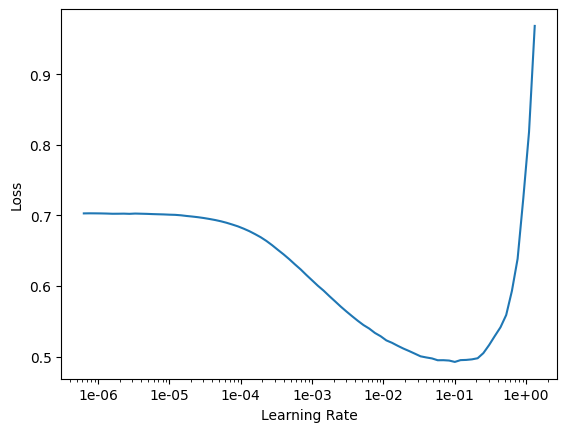

In [ ]:
# Finding learning rate
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.379132,0.617089,0.681233,0.057710,20:37
1,0.345357,0.524615,0.780812,0.085600,20:55
2,0.321402,0.317172,0.852381,0.546721,21:17
3,0.301616,0.298884,0.867927,0.616283,21:15
4,0.281824,0.264790,0.880112,0.662516,21:13


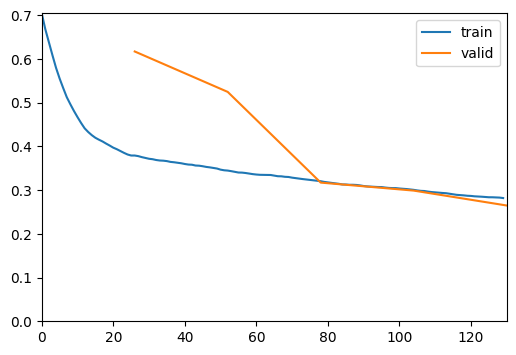

Better model found at epoch 0 with valid_loss value: 0.6170886158943176.
Better model found at epoch 1 with valid_loss value: 0.5246148705482483.
Better model found at epoch 2 with valid_loss value: 0.31717169284820557.
Better model found at epoch 3 with valid_loss value: 0.2988843321800232.
Better model found at epoch 4 with valid_loss value: 0.26478973031044006.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


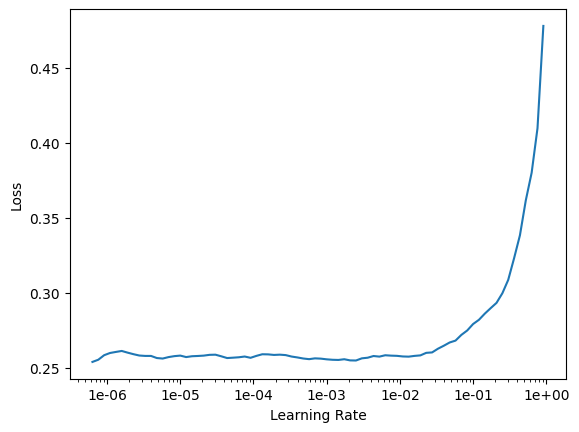

In [ ]:
# Training the model
learn.fit_one_cycle(5, 1e-2)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.254814,0.260384,0.878992,0.638654,20:59
1,0.250095,0.254771,0.885854,0.674917,20:47
2,0.243853,0.250157,0.885714,0.694505,20:27
3,0.238992,0.243380,0.891176,0.726426,21:16
4,0.234511,0.242137,0.892437,0.733692,21:04


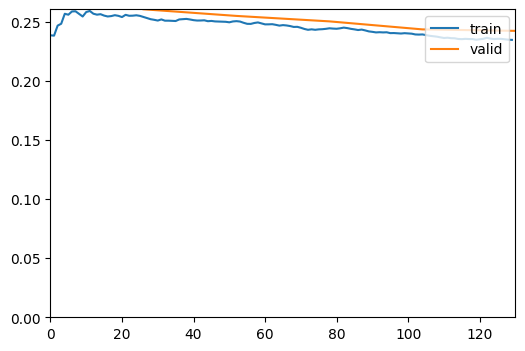

Better model found at epoch 0 with valid_loss value: 0.26038408279418945.
Better model found at epoch 1 with valid_loss value: 0.25477105379104614.
Better model found at epoch 2 with valid_loss value: 0.2501567006111145.
Better model found at epoch 3 with valid_loss value: 0.24337968230247498.
Better model found at epoch 4 with valid_loss value: 0.24213732779026031.


In [ ]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

In [ ]:
# Testing the model
!wget https://www.dropbox.com/s/6tt0t61uq2w1n3s/test.zip
!unzip test.zip


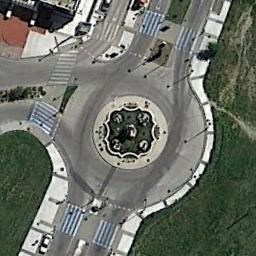

In [ ]:
img = open_image("test/roundabout_086.jpg")
img


In [ ]:
pred_class, pred_idx, outputs = learn.predict(img)
print(pred_class)

In [ ]:
pred_class, pred_idx, outputs = learn.predict(img)
print(pred_class)